In [2]:
import dolfin 
import mshr
import ufl
import matplotlib.pyplot as plt
import numpy as np
import mshr
%config Completer.use_jedi = False
%config IPCompleter.greedy = True

def generate_mesh(Lc=4,n_div=30,n_ref=5,R_ref=0.5,Lx=10,H1=1,H2=1):
    """
    Generate a polygonal mesh with:
        - Lc : crack length
        - n_div : number of divisions on the largest side
        - n_ref : number of refinements around the crack
        - r_ref : Radius for refinement around the crack
        - Lx : Length
        - H1 : Left side
        - H2 : Rigth side
    """
    p0 = dolfin.Point(0,0)
    pc = dolfin.Point(Lc,0)
    p1 = dolfin.Point(Lx,0)
    p2 = dolfin.Point(Lx,H2)
    p3 = dolfin.Point(0,H1)
    geom = mshr.Polygon([p0,pc,p1,p2,p3])
    mesh = mshr.generate_mesh(geom,n_div)
    
    for i in range(n_ref):
        cell_markers = dolfin.MeshFunction("bool", mesh, mesh.topology().dim())
        cell_markers.set_all(False)
        for cell in dolfin.cells(mesh):
            if cell.midpoint().distance(pc) < R_ref :
                cell_markers[cell] = True
        mesh = dolfin.refine(mesh, cell_markers)
    
    return mesh 


def eps(u):
    return dolfin.sym(dolfin.grad(u))

def sigma(epsilon):
    E = 1.
    nu = 0.3
    # Elasticity parameters
    mu = E/(2*(1.0 + nu)) # lame 1 (plane-strain)
    lmbda = E*nu/((1.0 + nu)*(1.0 -2.0*nu)) # lame 2 (plane-strain) 
    return  2*mu*epsilon + lmbda*dolfin.tr(epsilon)*dolfin.Identity(2)

def dcb_solver(Lc=4,n_div=30,n_ref=5,R_ref=0.5,Lx=10,H1=1,H2=1):
    
    mesh = generate_mesh(Lc=Lc,n_div=n_div,n_ref=n_ref,R_ref=R_ref,Lx=Lx,H1=H1,H2=H2)
    
    V = dolfin.VectorFunctionSpace(mesh, "Lagrange", 2)
    
    # Boundary conditions
    u0 = dolfin.Constant(0.0)
    u1 = dolfin.Constant(1)
    bc_bottom = dolfin.DirichletBC(V.sub(1), u0, f"on_boundary & near(x[1],0) && x[0] > {Lc}")
    bc_left = dolfin.DirichletBC(V.sub(1), u1, "on_boundary & near(x[0],0)")
    bc_right = dolfin.DirichletBC(V.sub(0), u0, f"on_boundary & near(x[0],{Lx})")
    bcs = [bc_right, bc_bottom, bc_left]
    
    # Variational formulation of the problem 
    
    u = dolfin.TrialFunction(V)
    v = dolfin.TestFunction(V)

    # bilinear form
    a = dolfin.inner(sigma(eps(u)), eps(v)) * dolfin.dx 
    
    # linear form
    
    # Bulk load 
    bulk_load = dolfin.Constant((0.,0.))
    L = dolfin.inner(bulk_load,v) * dolfin.dx
    
    A = dolfin.assemble(a)
    b = dolfin.assemble(L)
    for bc in bcs:
        bc.apply(A,b)
    
    usol = dolfin.Function(V)
    dolfin.solve(A,usol.vector(),b) 
    energy = 0.5 * dolfin.assemble(dolfin.inner(sigma(eps(usol)), eps(usol)) * dolfin.dx)

    return usol, energy

def create_theta_field(mesh,Lcrack,R_int,R_ext):

    V_theta = dolfin.FunctionSpace(mesh,"P",1)

    theta = dolfin.Function(V_theta)
    theta_test = dolfin.TestFunction(V_theta)
    theta_trial = dolfin.TrialFunction(V_theta)
   
    def inner_domain(x):
        return np.sqrt((x[0]-Lc)**2 + x[1]**2) < R_int
    
    def outer_domain(x):
        return np.sqrt((x[0]-Lc)**2 + x[1]**2) > R_ext
    
    one = dolfin.Function(V_theta)
    zero = dolfin.Function(V_theta)
    one.interpolate(dolfin.Constant(1.))
    bc_0 = dolfin.DirichletBC(V_theta, zero, outer_domain)
    bc_1 = dolfin.DirichletBC(V_theta, one, inner_domain)
        
    bcs = [bc_0, bc_1]
    
    a = ufl.dot(ufl.grad(theta_trial), ufl.grad(theta_test)) * ufl.dx
    L = zero * theta_test * ufl.dx 
    A, b = dolfin.assemble_system(a,L,bcs)
    dolfin.solve(A,theta.vector(),b)
    return theta

def compute_ERR(u,Lc,Rmin,Rmax):
    
    V = u.function_space()
    
    theta = create_theta_field(V.mesh(),Lc,Rmin,Rmax)
    
    eps_ = eps(u)
    sig_ = sigma(eps_)
    
    thetav = theta * ufl.as_vector([1,0])
    
    first_term = ufl.inner(sig_,ufl.grad(u) * ufl.grad(thetav)) * ufl.dx
    second_term = - 0.5 * ufl.inner(sig_,eps_) * ufl.div(thetav) * ufl.dx
    
    G_theta = 2 * dolfin.assemble(first_term + second_term )
    print(f'The ERR computed with the G-theta method is {G_theta:2.4f}' )
    return G_theta

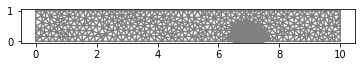

In [9]:
mesh = generate_mesh(Lc=7,n_div=30,n_ref=5,R_ref=0.5,Lx=10,H1=1,H2=1.)
dolfin.plot(mesh)

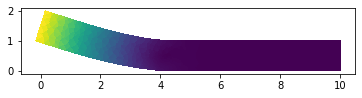

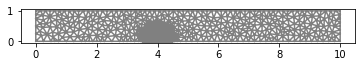

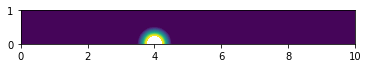

In [54]:
Lc = 4.
usol, energy = dcb_solver(Lc=Lc,n_div=30,n_ref=5,R_ref=0.5,Lx=10,H1=1,H2=1.)
dolfin.plot(usol,mode="displacement")
plt.figure()

V = usol.function_space()
mesh = V.mesh()
dolfin.plot(mesh)
V_theta = dolfin.FunctionSpace(mesh,'P',1)
theta = dolfin.Function(V_theta)

theta_trial = dolfin.TrialFunction(V_theta)
theta_test = dolfin.TestFunction(V_theta)

a = ufl.dot(ufl.grad(theta_trial),ufl.grad(theta_test)) * dolfin.dx 
L = dolfin.Constant(0.) * theta_test * dolfin.dx 

R_int = Lc/16.
R_ext = Lc/8.
def inner_domain(x):
    return np.sqrt((x[0]-Lc)**2 + x[1]**2) < R_int

def outer_domain(x):
    return np.sqrt((x[0]-Lc)**2 + x[1]**2) > R_ext

one = dolfin.Function(V_theta)
zero = dolfin.Function(V_theta)
one.interpolate(dolfin.Constant(1.))
bc_0 = dolfin.DirichletBC(V_theta, zero, outer_domain)
bc_1 = dolfin.DirichletBC(V_theta, one, inner_domain)
        
bcs = [bc_0, bc_1]
A,b = dolfin.assemble_system(a,L,bcs)
dolfin.solve(A,theta.vector(),b)
plt.figure()
dolfin.plot(theta)

e_1 = ufl.as_vector([1,0])
theta_v = theta * e_1


In [57]:
eps_sol = eps(usol)
sigma_sol = sigma(eps_sol)

W = 0.5 * ufl.inner(sigma_sol,eps_sol)

first_term = dolfin.assemble(ufl.inner(sigma_sol, ufl.grad(usol) * ufl.grad(theta_v) ) * dolfin.dx) 
second_term = - dolfin.assemble(W * ufl.div(theta_v) * dolfin.dx)
print(first_term)
print(second_term)

G = 2 * (first_term + second_term)
print(G)

Calling FFC just-in-time (JIT) compiler, this may take some time.
0.0008831992742237015
-2.253711110288833e-05
0.0017213243262416261


In [59]:
R_int = Lc/16.
R_ext = Lc/8.
compute_ERR(usol,Lc,R_int,R_ext)

Calling FFC just-in-time (JIT) compiler, this may take some time.
The ERR computed with the G-theta method is 0.0017


0.001721324326241628

# Q1
Let us denote by $P$ and $G$ the dimensionless potential energy and the dimensionless energy release rate obtained for a Young modulus $E=1$ and an applied displacement $t=1$ on a mesh with the same aspect ratio as the original geometry but with thickness at the left-end $H=1$. Show that the dimensional value of the energy $P_\mathrm{dimensional}$ and the energy release rate $G_\mathrm{dimensional}$ for a structure of thickness at the left-end $H$, Young modulus $E$ with applied displacement $t$ and with a depth $b$ are given by
$$
P_\mathrm{dimensional}={E \, b\, t^2}  P,\quad G_\mathrm{dimensional}=\frac{E\,b\, t^2}{H} G
$$
This will allows us to perform, without loss of generality, the numerical simulations on a mesh of thickness at the left-hand $H=1$ with $t=1$ and $E=1$.

# Q2 
Consider the following geometry and mesh, for which we provide a solver of the elastic problem below (`dcb_solver`) with a value of the value of the thickness at the right-hand $H_2$ given for your group (you should replace with this value the $H_2=1$ in the code below). Determine the dimensionless energy release rate $G$ for $L=4.$ using the following methods:

 a. Crack opening displacement
 
 b. G-$\theta$
 

In [ ]:
Lc = 4
Lx = 1.
mesh = generate_mesh(Lc=4,n_div=30,n_ref=5,R_ref=0.5,Lx=12,H1=1.0,H2=1.0)
dolfin.plot(mesh)
plt.plot([0,Lc],[0,0],"-r")

In [ ]:
usol, energy = dcb_solver(Lc=4,n_div=30,n_ref=5,R_ref=0.5,Lx=12.,H1=1.,H2=1.0)
dolfin.plot(usol,mode="displacement")

# Q3 
For the following numerical values (PMMA) $E = 2.4\,GPa$ , 
$H = 8\,mm$, $G_c=1.4 Nm^{-1}$, and considering a plate with a prexisting crack 
$\ell_0 = 32\,mm$, determine the critical displacement $t_c$ at which the crack start propagating.

# Q4 

Plot the energy release rate as a function of the crack length for $\ell\in[4,8]$ computed with:

a -  The G-$\theta$ method

b - The finite difference approximation of the potential energy

Compare the numerical results against the analytical results obtained with the beam theory approximation, and comment.

# Q5

Using the result of the previous question and the results of Lecture 4:
 
 a - Is the crack propagation at imposed displacement stable? Why?
 
 b - Provide a dimensionless plot of the crack length as a function of the applied displacement.
 
 c - Plot the global force-displacement diagram
 
 d - Would the propagation be stable at imposed force? Justify your answer using the material of the course.
